# Comparing IOTA8-2 dQ=-0.1 between Warp and Synergia

**August 8 2016 - Updated for use with new rssynergia name conventions**


**Parameters for SC Match**
- 20 mm-mrad emittance - KV distribution
- Nparticles = 1.25 * 10^7/cm == 4.75 mA without bunching = Tune depression -0.1


## Imports

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys, os
del sys.argv[1:] #do this to avoid import errors associated with the Jupyter notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import constants
from scipy.interpolate import interp1d
import tables
from mpi4py import MPI

#sys.path.append('/home/vagrant/jupyter/beamsim/synergia/') #added specifically for nifak.radiasoft.org - can ignore

In [4]:
from rssynergia.base_diagnostics import read_bunch
from rssynergia.base_diagnostics import workflow
from rssynergia.base_diagnostics import lfplot
from rssynergia.base_diagnostics import latticework
from rssynergia.base_diagnostics import basic_calcs
from rssynergia.base_diagnostics import pltbunch
from rssynergia.base_diagnostics import elliptic_sp
from rssynergia.base_diagnostics import singleparticle
from rssynergia.base_diagnostics import options
from rssynergia.base_diagnostics import diagplot
from rssynergia.base_diagnostics import utils

from rssynergia.elliptic import elliptic_beam6d
from rssynergia.standard import standard_beam6d

import synergia
import synergia_workflow

In [ ]:
#Run Check - Don't Accidentally Re-run particle tracking
alreadyRun = True

if 'alreadyRun' in globals():
    print "alreadyRun flag is set to: %s" % alreadyRun
if not 'alreadyRun' in globals():
    alreadyRun = False
    print "Set alreadyRun == False. You can run Synergia"


## Load options and lattices

In [6]:
#load options for SC_test
from SC_test_options import opts

#================== Setting up logger and MPI comunicator ============================
#try:
#if True:
# this is the communicator object that will be used for MPI operations
comm = synergia.utils.Commxx()
myrank = comm.get_rank()
mpisize = comm.get_size()
verbose = opts.verbosity>0

logger = synergia.utils.Logger(0)


if myrank == 0:
    print "my rank is 0"
else:
    print "not rank 0"

my rank is 0


In [7]:
#================== Load the lattice =======================

lattices = {}
dir_66 = '/home/vagrant/jupyter/ioptics/ioptics/lattices/Iota6-6/'
dir_82 = '/home/vagrant/jupyter/ioptics/ioptics/lattices/Iota8-2/'
lattices['t1_1IO_66'] = dir_66 + "lattice_1IO_center.madx" #centered t1 6.6 1IO lattice
lattices['t3_1IO_66'] = dir_66 + "lattice_1IO_nll_center.madx" #centered t3 6.6 1IO lattice
lattices['t1_1IO_82_uncentered'] = dir_82 + "lattice_1IO.madx" #uncentered tier1 8.2 lattice
lattices['t1_1IO_82'] = dir_82 + "lattice_1IO_center.madx" #this is the new tier1 8.2 (zero current) lattice

lattices['t1_1IO_82_dQ_1'] = dir_82 + "lattice_1IO_dQ_1.madx" #t1 8.2 lattice adjusted for dQ = -0.1

lattices['t1_1IO_82_dQ'] = dir_82 + "lattice_1IO_dQ_2.madx" #t1 8.2 lattice adjusted for dQ = -0.2
lattices['t3_1IO_82'] = dir_82 + "lattice_1IO_nll_center.madx" #this is the centerted t3 8.2 lattice
lattices['t3_1IO_82_dQ'] = dir_82 + "lattice_1IO_nll_dQ_2.madx" #t3 8.2 lattice adjusted for dQ = -0.2

In [8]:
#================= Construct a Python dictionary of lattice stuff ==================
lattice_dict = {}

for keys in lattices.keys():
    lattice_dict[keys] = {} #instantiate sub dictionary
    lattice_dict[keys]['name'] = keys
    lattice_dict[keys]['location'] = lattices[keys]
    lattice_dict[keys]['lattice'] = synergia.lattice.MadX_reader().get_lattice("iota", lattices[keys])

In [9]:
reference_particle = lattice_dict['t1_1IO_82_dQ_1']['lattice'].get_reference_particle()
energy = reference_particle.get_total_energy()
opts.beta = reference_particle.get_beta()
opts.gamma = reference_particle.get_gamma()


#================== Setting up the options =======================

order = 1
nsteps_per_element = 4
n_ppc = 100

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
#n_macro = 6*60 #60 particles per core when running on 6 cores 

tval = 0.4
cval = 0.01

outputdir = "diagnostics"

nsteps = len(lattice_dict['t1_1IO_82_dQ_1']['lattice'].get_elements())*nsteps_per_element
opts.output_dir = outputdir
opts.relpath = opts.output_dir
opts.macro_particles = n_macro
opts.steps = nsteps
opts.steps_per_element = nsteps_per_element
workflow.make_path(outputdir)

print >>logger, "output directory:", opts.output_dir


#==================== Set up space charge solver ==========================

#turn off space charge
opts.spacecharge = True

requested_stepper = opts.stepper
if opts.spacecharge:
    
    solver = opts.solver
    # space charge only works with the split operator stepper, or soelements 
    if (requested_stepper != "splitoperator") and (requested_stepper != "soelements"):
        requested_stepper = "soelements"
        print "Requested stepper changed to soelements for space charge"

    #force these
    gridx = 32
    gridy = 32
    gridz = 1
    grid = [gridx, gridy, gridz]

    print >>logger, "grid: ", grid

    #opts.comm_divide = None
    if opts.comm_divide:
        sc_comm = synergia.utils.Commxx_divider(opts.comm_divide, False)
    else:
        sc_comm = synergia.utils.Commxx(True)

    #sc_comm = synergia.utils.Commxx(True)
    if solver == "2dopen-hockney":
        coll_operator = synergia.collective.Space_charge_2d_open_hockney(sc_comm, grid)
    elif solver == "3dopen-hockney":
        # full signature for 3d_open_hockney constructor is
        # comm, grid, long_kicks, z_periodic, period, grid_entire_period,
        # nsigma

        coll_operator = synergia.collective.Space_charge_3d_open_hockney(sc_comm, grid, opts.long_kicks, False, 0.0, False, opts.nsigma)
    elif solver == "2dbassetti-erskine":
        coll_operator = synergia.collective.Space_charge_2d_bassetti_erskine()
    else:
        raise RuntimeError, "requested space charge operator %s invalid.  Must be either 2dopen-hockney or 3dopen-hockney"%opts.solver

    print "Using space charge solver ", solver
    print "Grid: ", gridx, " x ", gridy, " x ", gridz

else:
    coll_operator = synergia.simulation.Dummy_collective_operator("stub")
    print "No space charge solver used"

#opts.use_maps = 'none'
#now set element type and construct stepper
print "use maps for: {}".format(opts.use_maps)
print "requested_stepper: {}".format(requested_stepper)

#for key in lattices.keys():
    
#    current_lattice = synergia.lattice.MadX_reader().get_lattice("iota", lattices[key])
#    lattice_dict[key]['lattice'] = latticework.set_lattice_element_type(current_lattice,opts)

        
#================== Setting up the stepper and lattice simulator =======================

for key in lattices.keys():
    
    current_lattice = lattice_dict[key]['lattice']
    lattice_dict[key]['stepper'] = latticework.generate_stepper(current_lattice,coll_operator, opts)
    lattice_dict[key]['lattice_simulator'] = lattice_dict[key]['stepper'].get_lattice_simulator()

Using space charge solver  2dopen-hockney
Grid:  32  x  32  x  1
use maps for: none
requested_stepper: splitoperator
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn
Using split-operator stepper with  1368  steps/turn


In [15]:
print "For t1 v6.6 lattice:" + str(lattice_dict['t1_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t3 v6.6 lattice:" + str(lattice_dict['t3_1IO_66']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice:" + str(lattice_dict['t1_1IO_82']['lattice_simulator'].get_both_tunes())
print "For t1 v8.2 lattice - detuned:" + str(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'].get_both_tunes())
#print "For t1 v8.2 uncentered lattice:" + str(lattice_dict['t1_1IO_82_uncentered']['lattice_simulator'].get_both_tunes())
print "For t3 v8.2 lattice:" + str(lattice_dict['t3_1IO_82']['lattice_simulator'].get_both_tunes())

For t1 v6.6 lattice:(0.300064734030028, 0.3000459461883418)
For t3 v6.6 lattice:(0.40264398946138624, 0.3000459461883418)
For t1 v8.2 lattice:(0.30007507878938977, 0.3000355421087709)
For t1 v8.2 lattice - detuned:(0.39844408797194025, 0.3987698808433909)
For t3 v8.2 lattice:(0.4026532305504392, 0.3000355421087709)


/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


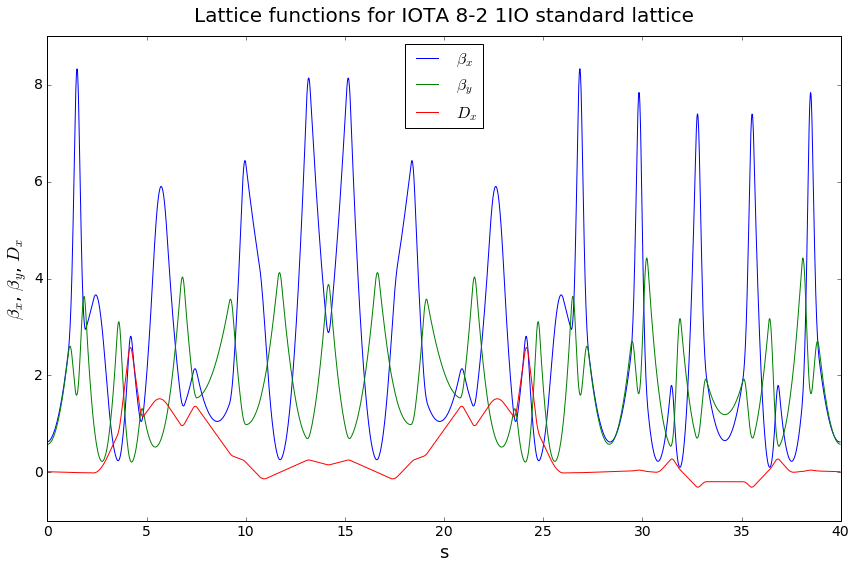

In [10]:
opts.save = False
opts.lattice_name = 'IOTA 8-2 1IO standard lattice'
opts.lf_fns = ['beta_x','beta_y','D_x']
opts.lattice = lattice_dict['t1_1IO_82_dQ_1']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator']
lfplot.plot_sliced_lattice_functions(opts)

# Get Initial Lattice Parameters for Use in Warp

In [11]:
#Initial twiss parameters from Synergia lattice
lf_names = ("beta_x", "alpha_x", "beta_y", "alpha_y", 
        "psi_x", "psi_y","D_x", "Dprime_x", "D_y", "Dprime_y")
lf = {}
for lfname in lf_names:
    lf[lfname] = np.empty([0,0])

for element in lattice_dict['t1_1IO_82_dQ_1']['lattice'].get_elements():
    lattice_functions = lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'].get_lattice_functions(element)
    for lfname in lf_names:
        lf[lfname] = np.append(lf[lfname],getattr(lattice_functions,lfname))

test11 = lattice_dict['t1_1IO_82_dQ_1']['lattice']
test11.as_string
        
print "Initial parameters for lattice: \nbetax = %s\nbetay = %s\nalphax = %s\nalphay = %s" % (lf['beta_x'][0], lf['beta_y'][0],lf['alpha_x'][0],lf['alpha_y'][0])

Initial parameters for lattice: 
betax = 0.62735678467
betay = 0.579784128813
alphax = -0.0342380507197
alphay = 0.0232503120774


## Construct the beam and propagate it

In [12]:
opts.lattice = lattice_dict['t1_1IO_82_dQ_1']['lattice']
opts.lattice_simulator = lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator']
opts.stepper = lattice_dict['t1_1IO_82_dQ_1']['stepper']

In [13]:
def dQ_SC_Gauss(N,emit,ref):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ

def dQ_SC_Gauss_2(N,emit,bet,gam):
    '''Return dQsc if given normalized emittance'''
    r0 = 1.54e-18 #classical proton radius
    
    dQ = -1.*r0*N/(4*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


def dQ_SC_KV(N,emit,ref):
    '''Return dQsc for a KV beam if given normalized emittance (2x that of Gaussian)'''
    r0 = 1.54e-18 #classical proton radius
    bet = ref.get_beta()
    gam = ref.get_gamma()
    
    dQ = -1.*r0*N/(2*np.pi*emit*bet*gam*gam)
    #print gam*gam*gam
    #print bet*bet
    
    return dQ


g_emit = 20.e-6 #TOTAL geometric emittance according to Sasha
n_emit = basic_calcs.calc_normalized_emittance(g_emit,opts.beta,opts.gamma)

current = 4.25*1.e-3 #mA of current 
l_IOTA = 39.968229715800064 #length of lattice
#n_emit = 3.e-7 #normalized emittance for IOTA ring for this current
rp_perlength = current/(reference_particle.get_beta()*scipy.constants.c*scipy.constants.e)
n_particles = rp_perlength*l_IOTA

dQ = dQ_SC_Gauss(n_particles,n_emit,reference_particle) #calc dQsc_x
dQ_KV = dQ_SC_KV(n_particles,n_emit,reference_particle) #calc dQsc_x

print "Assume a normalized total emittance of {} mm-mrad.".format(n_emit*1.e6)
print "At {} mA current, # of protons filling ring is {:e} or {:e} p+/cm.".format(current*1.e3,n_particles,n_particles/(100.*l_IOTA))
print "Corresponding space charge tune shift in x is {} for KV distribution".format(dQ_KV)

Assume a normalized total emittance of 1.46096398318 mm-mrad.
At 4.25 mA current, # of protons filling ring is 4.854213e+10 or 1.214518e+07 p+/cm.
Corresponding space charge tune shift in x is -0.111187269489 for KV distribution


In [16]:
n_ppc = 10

opts.gridx = 32
opts.gridy = 32
opts.gridz = 1

n_macro = n_ppc*opts.gridx*opts.gridy
opts.macro_particles = n_macro

#======================= Now setup the bunch and other related options =====================
opts.t = tval
opts.c = cval
opts.new_tune = 0.3
opts.lnll = 1.8
opts.nseg = 20
vals = basic_calcs.get_base_nll(opts.lnll, opts.new_tune, opts.t, opts.c)

toy_model = False

if toy_model:
    #specify twiss for center of the section using calculated twiss parameters
    opts.betae = vals[3]
    opts.alphae = 0 #fix alpha=0 for center
    opts.beta0 = vals[3]
else:
    #Get immediate beta value from lattice simulator and match to this instead
    new_vals = latticework.get_starting_lf(lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'])
    opts.betae = new_vals[0]
    opts.alphae = 0 #fix alpha=0 for center
    opts.beta0 = new_vals[0]


dpop = 0.0
opts.dpop = dpop

current = 4.25e-3 #mA of current 
rp_perlength = current/(opts.beta*constants.c*constants.e)
bunch_length = opts.lattice.get_length() #effective bunch length is iota lattice length
opts.real_particles = rp_perlength*bunch_length

opts.emit = 0.5 * g_emit
opts.emits = [opts.emit]

if myrank == 0:
    #construct a bunch and make sure to add longitudinal momentum variation
    #particles = SemiGaussian6D.semiGaussianBeam6D(opts)
    particles = standard_beam6d.toyKVbeam6D(opts)

    for index in range(len(opts.emits)):
        bunch = particles[index]
        #initialH,initialI = elliptic_sp.calc_bunch_H(bunch,opts)
        #bunch_mean = np.mean(initialH)
        #bunch_std = np.std(initialH)
        #bunch_var = (bunch_std/bunch_mean)*100
        #print "Constructed bunch with {} macroparticles, having mean H: {} and std: {}%".format(opts.macro_particles, bunch_mean,bunch_var)
        #now add longitudinal momentum variation
        #For random samples with mean = 0, sigma = sigma, use sigma*np.random.randn(...)
        #bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch))
        bunch[:,4] = bunch_length*(np.random.random(len(bunch)) -0.5) #center at 0
        bunch[:,5] = opts.dpop*np.random.randn(1,len(bunch)) #set dp/p

    np.savetxt('my_KV_bunch_82.txt',bunch)         #write the bunch to a text file


bucket_length = bunch_length
particles_file = 'my_KV_bunch_82.txt'
myBunch = read_bunch.read_bunch(particles_file, reference_particle, opts.real_particles, bucket_length, comm)

# generated longitudinal coordinate is z position (beta*c*dt) but Synergia uses
# c*dt.  Divide by beta to get c*dt.
local_particles = myBunch.get_local_particles()
local_particles[:,4] /= opts.beta

Initial starting lattice functions: betax = 0.627584360895, betay = 0.579814047034, alphax = -0.0343278194109, alphay = 0.0232141438299
Loading Synergia particles from txt file:  my_KV_bunch_82.txt
Read  10240  particles


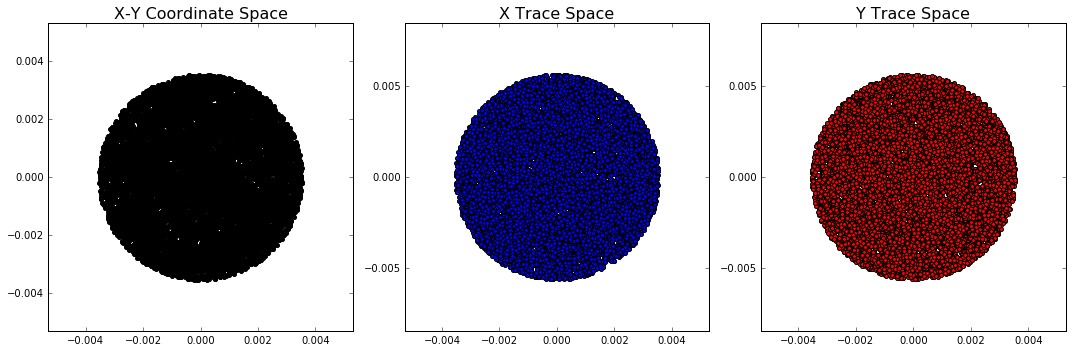

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=-0.0
  'bottom=%s, top=%s') % (bottom, top))


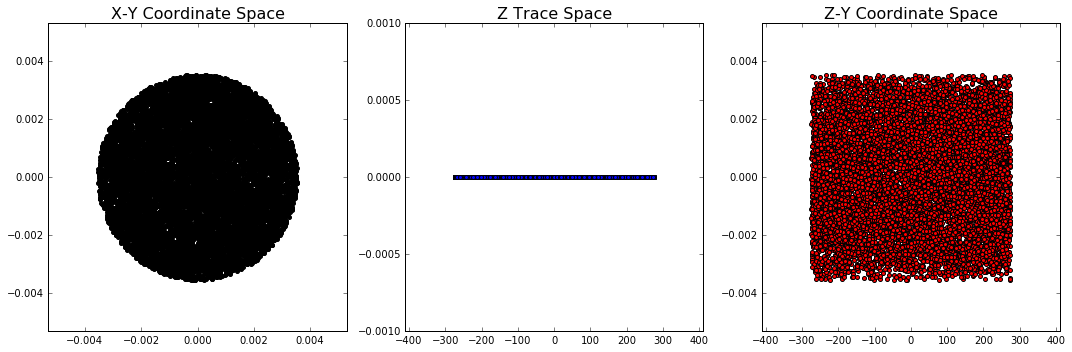

In [17]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [18]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.76283746063 mm
rms envelope y: 1.77591176371 mm
maximum x value is : 3.53243342517 mm
maximum y value is : 3.52823618638 mm
rms beta x: 0.621090115764
rms beta y: 0.631253498616
geometric emittance x: 5.00345414255 mm-mrad
geometric emittance y: 4.99619027759 mm-mrad
normalized emittance x: 0.365493314689 mm-mrad
normalized emittance y: 0.364962702434 mm-mrad
mean of xp^2 : 8.05592299018e-06
mean of yp^2 : 7.91471300918e-06
total geometric emittance x: 20.0906206467 mm-mrad
total geometric emittance y: 19.7202084649 mm-mrad


In [39]:
outputdir = 'Benchmark-8pt5-LINEAR'

opts.output_dir = outputdir
workflow.make_path(outputdir)

bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5", opts.output_dir)
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5", opts.output_dir)
bunch_simulator.add_per_turn(fulldiag)

#particle diagnostics - PER TURN
opts.turnsPerDiag = 1
particlediag = synergia.bunch.Diagnostics_particles("particles.h5",0,0,opts.output_dir)
bunch_simulator.add_per_turn(particlediag, opts.turnsPerDiag)

In [ ]:
opts.turns = 250
opts.checkpointperiod = 10
opts.maxturns = opts.turns+1

propagator = synergia.simulation.Propagator(opts.stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator,opts.turns, opts.maxturns,opts.verbosity)

workflow.cleanup(opts.output_dir)

## Analysis

### Analysis - Beam Envelopes

In [41]:
opts.relpath = opts.output_dir

opts.inputfile = opts.output_dir + '/basic.h5'
opts.plots = ['x_std', 'y_std']
plotVals = diagplot.getPlotVals(opts.inputfile, opts.plots)

#define specific value arrays
xmaster = plotVals['s']
xstd = plotVals['x_std']
ystd = plotVals['y_std']

#we want to plot turn 0 and turn 100 on the same plot, so we should separate these specifically
interval = opts.steps 
xstd_0 = xstd[:interval]
xstd_2 = xstd[1*interval:2*interval]
xstd_end = xstd[-1*interval:] 

ystd_0 = ystd[:interval]
ystd_end = ystd[-1*interval:] 

#We can use the same s value for each plot
sval_0 = xmaster[:interval]

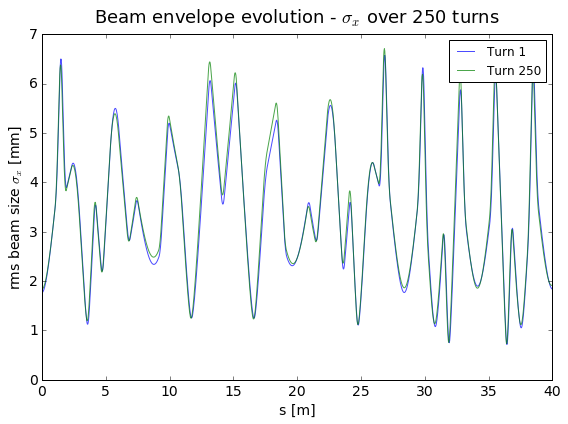

In [42]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,xstd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,xstd_end*1.e3,'g-',alpha=0.7, label='Turn %s' % opts.turns) #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_x$ over %s turns" % opts.turns
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = 'beam_envelope_x_compare_1mA_2D-600turns.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

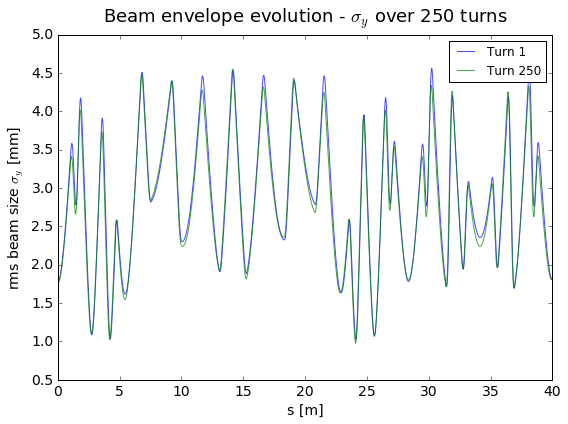

In [43]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
ax.plot(sval_0,ystd_0*1.e3,'b-',alpha=0.7, label='Turn 1') #plot the 1st turn
ax.plot(sval_0,ystd_end*1.e3,'g-',alpha=0.7, label='Turn %s' % opts.turns) #plot the 1st turn
axtitle = "Beam envelope evolution - $\sigma_y$ over %s turns" % opts.turns
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_y$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
sv_title = 'beam_envelope_y_compare_1mA_2D-600turns.pdf'
fig.tight_layout()
#fig.savefig(sv_title,bbox_inches='tight')

### Analysis - Bunch Properties

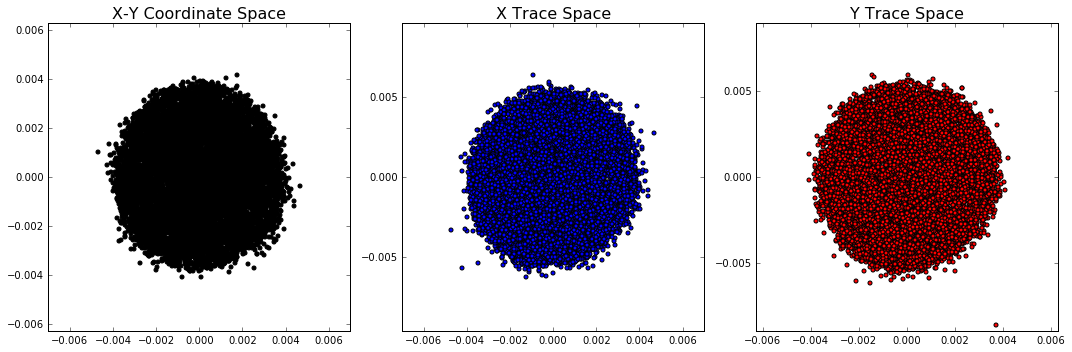

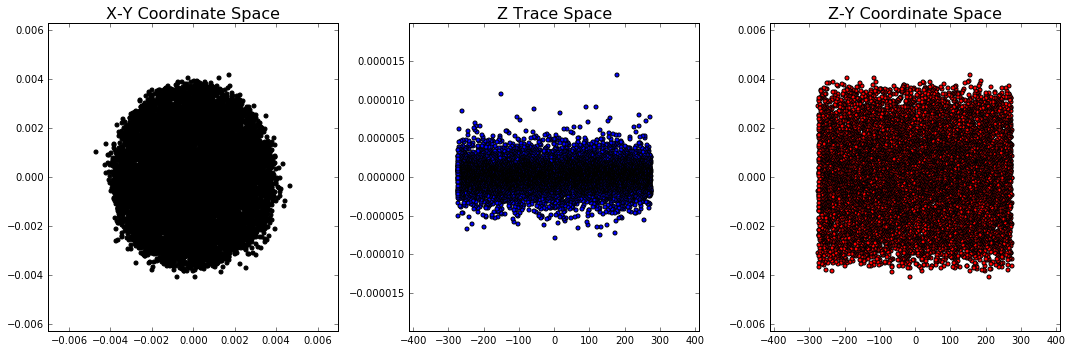

In [44]:
pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

In [45]:
basic_calcs.calc_properties(myBunch,reference_particle)

rms envelope x: 1.91646577238 mm
rms envelope y: 1.80950927795 mm
maximum x value is : 4.66570496073 mm
maximum y value is : 4.1857646329 mm
rms beta x: 0.703289607078
rms beta y: 0.67948456566
geometric emittance x: 5.22237357091 mm-mrad
geometric emittance y: 4.81883473512 mm-mrad
normalized emittance x: 0.381484984691 mm-mrad
normalized emittance y: 0.352007199446 mm-mrad
mean of xp^2 : 7.42563734535e-06
mean of yp^2 : 7.0918972684e-06
total geometric emittance x: 30.9528287657 mm-mrad
total geometric emittance y: 25.7851707714 mm-mrad


In [47]:
files = elliptic_sp.get_file_list(opts)
twiss = twiss = elliptic_sp.get_toy_twiss(opts)

rms_table = []


for inputfile in files:
    fn = inputfile[-7:-3]
    
    parts = elliptic_sp.get_particles(inputfile)[1]
    header= {}
    header['s_val'] = 0.
    #norm_coords = elliptic_sp.normalized_coordinates(header, part_array, twiss)
    
    x_rms = basic_calcs.get_rms_envelope('x',parts)
    y_rms = basic_calcs.get_rms_envelope('y',parts)
    
    rms_table.append((int(fn),x_rms,y_rms))
    
    #print "File {} : xrms = {:.2f} mm and yrms = {:.2f} mm".format(fn, x_rms*1.e3, y_rms*1.e3)
    
rms_array = np.asarray(rms_table)

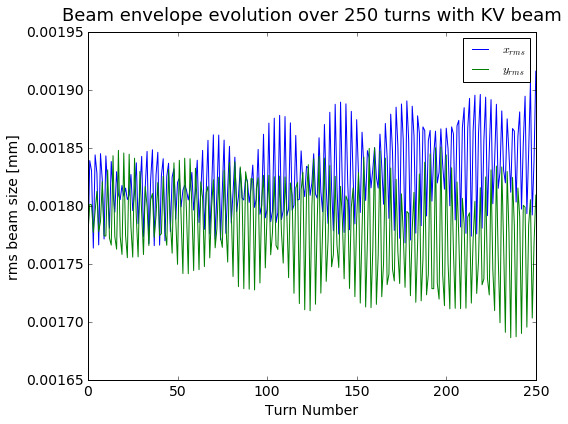

In [388]:
num_turns = rms_array.shape[0]-1

fig = plt.figure(figsize = (8,6))
plt.subplot(1,1,1)
ax = plt.gca()

ax.plot(rms_array[:,0],rms_array[:,1], label = '$x_{rms}$')
ax.plot(rms_array[:,0],rms_array[:,2], label = '$y_{rms}$')

axtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("Turn Number",fontsize=14)
ax.set_ylabel("rms beam size [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,num_turns])
ax.legend()
sv_title = 'Benchmark_KV_{}turns_20mm-total-emittance.pdf'.format(num_turns)
fig.tight_layout()
fig.savefig(sv_title,bbox_inches='tight')

np.savetxt("envelopeOsc_iota82_lin_dQm0p1.txt", np.array([rms_array[:,0],rms_array[:,1],rms_array[:,0],rms_array[:,2]]))

plt.show()

(232,) (232,)


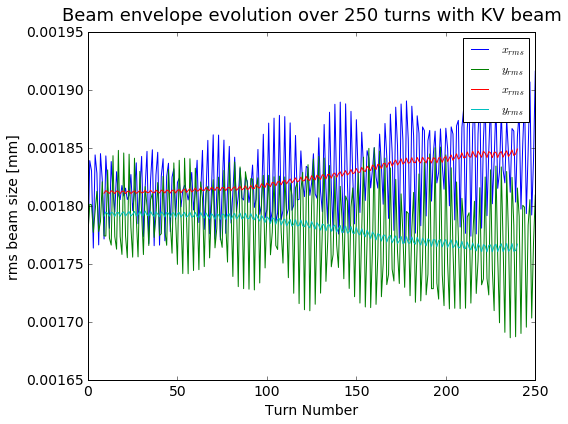

In [49]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
print moving_average(rms_array[:,1]).shape,rms_array[9:241,1].shape
num_turns = rms_array.shape[0]-1

fig = plt.figure(figsize = (8,6))
plt.subplot(1,1,1)
ax = plt.gca()

ax.plot(rms_array[:,0],rms_array[:,1], label = '$x_{rms}$')
ax.plot(rms_array[:,0],rms_array[:,2], label = '$y_{rms}$')

ax.plot(rms_array[9:241,0],moving_average(rms_array[:,1]), label = '$x_{rms}$')
ax.plot(rms_array[9:241,0],moving_average(rms_array[:,2]), label = '$y_{rms}$')

axtitle = "Beam envelope evolution over {} turns with KV beam".format(num_turns)
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("Turn Number",fontsize=14)
ax.set_ylabel("rms beam size [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,num_turns])
ax.legend()
sv_title = 'Benchmark_KV_{}turns_20mm-total-emittance.pdf'.format(num_turns)
fig.tight_layout()


plt.show()

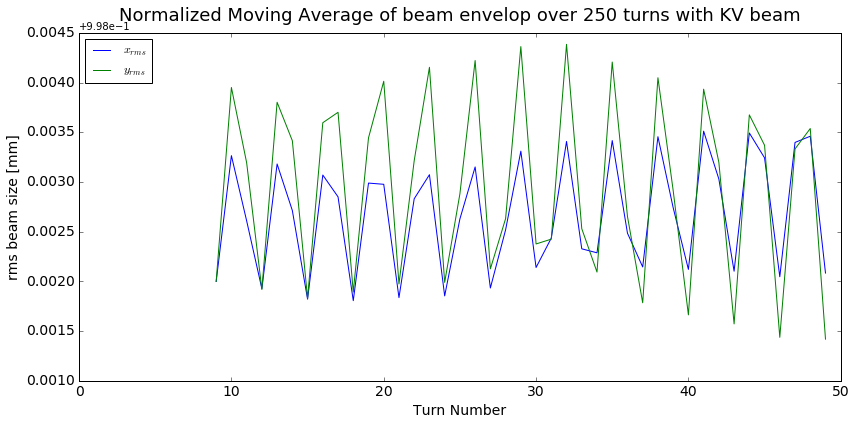

In [396]:
fig = plt.figure(figsize = (12,6))
plt.subplot(1,1,1)
bx = plt.gca()
bx.plot(rms_array[9:50,0],moving_average(rms_array[0:60,1]) / moving_average(rms_array[:,1])[0], label = '$x_{rms}$')
bx.plot(rms_array[9:50,0],moving_average(rms_array[0:60,2]) / moving_average(rms_array[:,2])[0], label = '$y_{rms}$')

bxtitle = "Normalized Moving Average of beam envelop over {} turns with KV beam".format(num_turns)
bx.set_title(bxtitle, y = 1.02, fontsize = 18)  
bx.set_xlabel("Turn Number",fontsize=14)
bx.set_ylabel("rms beam size [mm]",fontsize=14)
bx.tick_params(axis='x', labelsize=14)
bx.tick_params(axis='y', labelsize=14)
bx.set_xlim([0,50])
bx.legend(loc=2)

plt.show()

# Plot Beam Envelopes and Compare Warp and Synergia

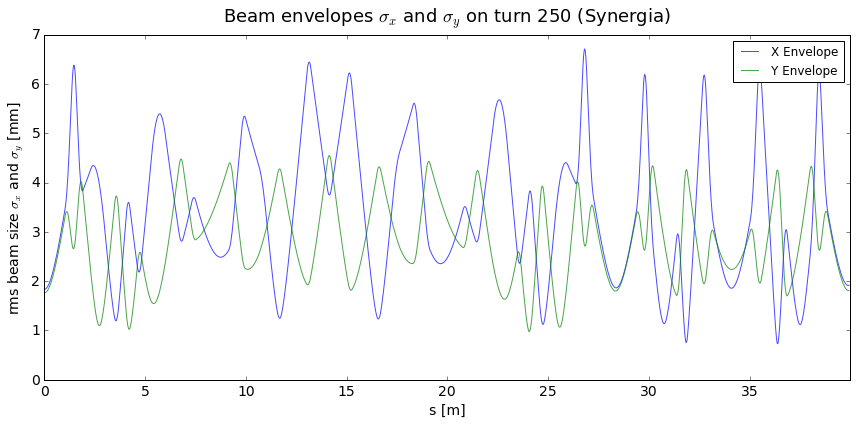

In [52]:
fig = plt.figure(figsize=(12,6))
ax = plt.gca()
ax.plot(sval_0,xstd_end*1.e3,'b-',alpha=0.7, label='X Envelope') #plot the 1st turn
ax.plot(sval_0,ystd_end*1.e3,'g-',alpha=0.7, label='Y Envelope') #plot the 1st turn
axtitle = "Beam envelopes $\sigma_x$ and $\sigma_y$ on turn %s (Synergia)" % opts.turns
ax.set_title(axtitle, y = 1.02, fontsize = 18)  
ax.set_xlabel("s [m]",fontsize=14)
ax.set_ylabel("rms beam size $\sigma_x$ and $\sigma_y$ [mm]",fontsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlim([0,opts.lattice.get_length()])
ax.legend()
fig.tight_layout()

# Warp/Synergia Comparison w/ Space Charge ON

In [106]:
#Load rms xy from Warp with Dedge included and SC
warpData = np.loadtxt('rms_iota82-dQ0p1_SC.txt')

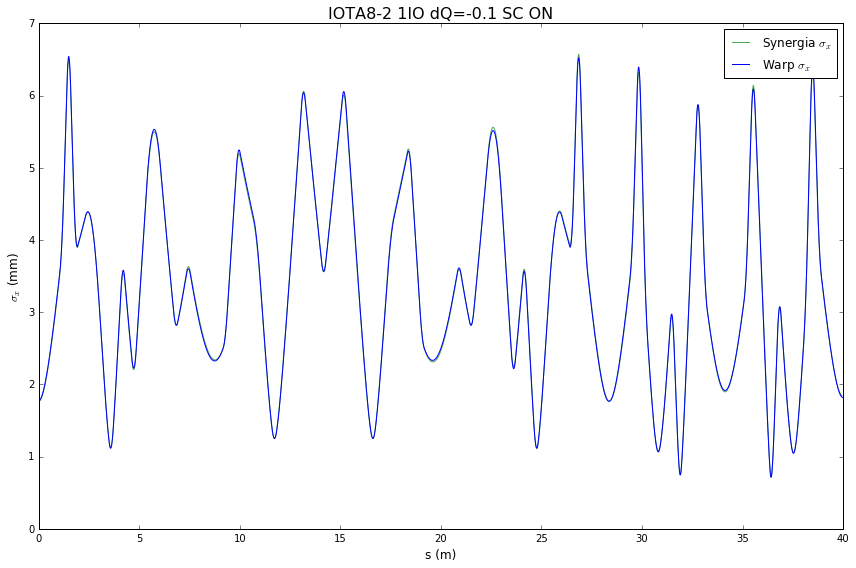

0.626395081882 0.662057134105 0.62124829193 0.676541546122


In [226]:
#Plot sig_x
plt.plot(sval_0,xstd_0*1000,'g-',alpha=0.7, label='Synergia $\sigma_x$')
plt.plot(warpData[:,0],warpData[:,1]*1000,label="Warp $\sigma_x$")

plt.legend()
plt.title("IOTA8-2 1IO dQ=-0.1 SC ON")
plt.xlabel("s (m)")
plt.ylabel("$\sigma_x$ (mm)")

#plt.savefig("sigx_IOTA82_1NL_dQm0p1_1turnWS.eps",format="eps")
plt.show()
print warpData[0,1]**2 / 5e-6, warpData[3999,1]**2 / 5e-6, xstd_0[0]**2/5e-6, xstd[len(ystd_0 - 1)]**2/5e-6

In [249]:
#Use Warp data to get cubic interpolation
fWx = interp1d(warpData[:,0],warpData[:,1],kind='cubic')
print "Finished x interpolation"
fWy = interp1d(warpData[:,0],warpData[:,2],kind='cubic')
print "Finished y interpolation"

Finished x interpolation
Finished y interpolation


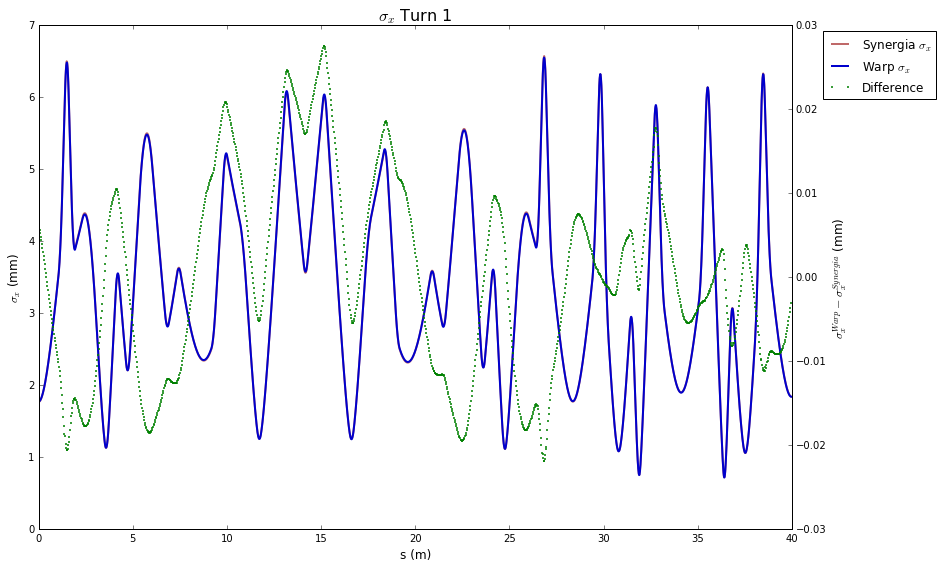

In [367]:
#Plot residual using slice positions from Synergia to find vales from Warp interpolation
fig, ax1 = plt.subplots(figsize=(12,8))
#ax1.set_position()

ax1.plot(sval_0,xstd_0*1000,alpha=0.7, color='brown',linewidth=2, label='Synergia $\sigma_x$')
ax1.plot(sposW[:],warpSigX[1][:]*1000, color='mediumblue',linewidth=2, label="Warp $\sigma_x$")
ax1.set_xlabel("s (m)")
ax1.set_ylabel("$\sigma_x$ (mm)")

ax2 = ax1.twinx()
ax2.plot(sval_0[1:],(fWx1(sval_0[1:])-xstd_0[1:])*1000,'.', color='g',markersize=3, label="Difference")
ax2.set_ylabel("$\sigma^{Warp}_x - \sigma^{Synergia}_x$ (mm)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0,bbox_to_anchor=(1.2, 1.00))

ax2.set_title("$\sigma_x$ Turn 1")



#plt.savefig("sigx_IOTA82_1NL_dQm0p1_1turnWS.eps",format="eps",bbox_inches='tight')
plt.show()

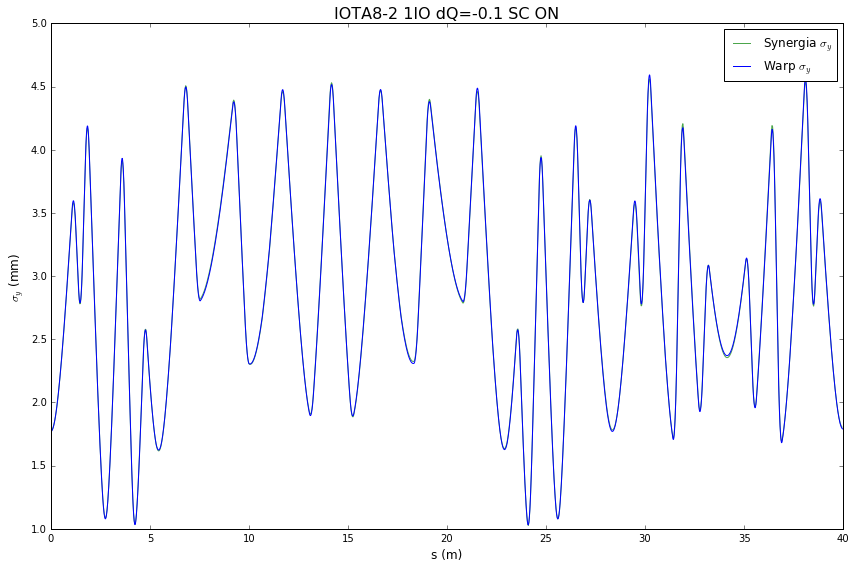

0.626760368245 0.641402202294 0.630767156021 0.649097039238


In [167]:
#Plot sig_y
plt.plot(sval_0,ystd_0*1000,'g-',alpha=0.7, label='Synergia $\sigma_y$')
plt.plot(warpData[:,0],warpData[:,2]*1000,label="Warp $\sigma_y$")
plt.legend()

plt.legend()
plt.title("IOTA8-2 1IO dQ=-0.1 SC ON")
plt.xlabel("s (m)")
plt.ylabel("$\sigma_y$ (mm)")

#plt.savefig("sigy_IOTA82_1NL_dQm0p1_1turnWS.eps",format="eps")
plt.show()
print warpData[0,2]**2 / 5e-6, warpData[3999,2]**2 / 5e-6, ystd_0[0]**2/5e-6, ystd[len(ystd_0 - 1)]**2/5e-6

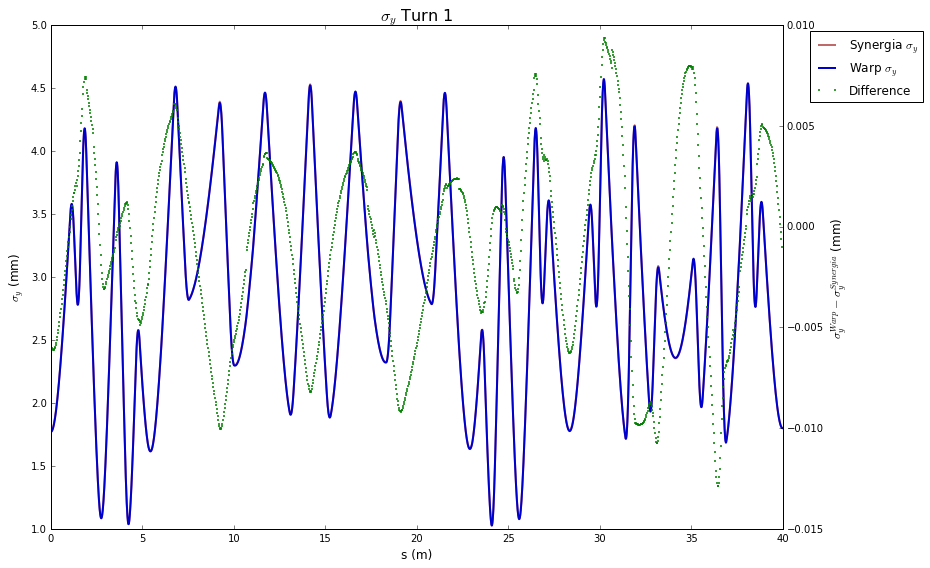

In [368]:
#Plot residual using slice positions from Synergia to find vales from Warp interpolation
fig, ax1 = plt.subplots()
ax1.plot(sval_0,ystd_0*1000,alpha=0.7, color='brown',linewidth=2, label='Synergia $\sigma_y$')
ax1.plot(sposW[:],warpSigY[1][:]*1000, color='mediumblue',linewidth=2, label="Warp $\sigma_y$")
ax1.set_xlabel("s (m)")
ax1.set_ylabel("$\sigma_y$ (mm)")

ax2 = ax1.twinx()
ax2.plot(sval_0[1:],(fWy1(sval_0[1:])-ystd_0[1:])*1000,'.',markersize=3, color='g', label="Difference")
ax2.set_ylabel("$\sigma^{Warp}_y - \sigma^{Synergia}_y$ (mm)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0,bbox_to_anchor=(1.2, 1.00))

ax2.set_title("$\sigma_y$ Turn 1")



#plt.savefig("sigy_IOTA82_1NL_dQm0p1_1turnWS.eps",format="eps",bbox_inches='tight')
plt.show()

# Multi-Turn Comparison

In [376]:
#Import h5 diagnostic results for test comparison
import h5py as h5
warph5Diag = h5.File('beamEnvelope_matched.h5','r')
sposW = warph5Diag['1/spos']
sigx1 = warph5Diag['1/sigx']
sigx50 = warph5Diag['50/sigx']
sigy1 = warph5Diag['1/sigy']
sigy50 = warph5Diag['50/sigy']
warpSigX = {}
warpSigY = {}
warpEpsX = {}
warpEpsY = {}
for i in range(50):
    warpSigX[i+1] = warph5Diag['%s/sigx' % (i+1)]
    warpSigY[i+1] = warph5Diag['%s/sigy' % (i+1)]
    warpEpsX[i+1] = warph5Diag['%s/epsx' % (i+1)]
    warpEpsY[i+1] = warph5Diag['%s/epsy' % (i+1)]
    
warpSigX[50]

<HDF5 dataset "sigx": shape (4001,), type "<f8">

In [335]:
#Use Warp data to get cubic interpolation
fWx50 = interp1d(sposW[:],warpSigX[50],kind='cubic')
fWy50 = interp1d(sposW[:],warpSigY[50],kind='cubic')

In [357]:
#Use Warp data to get cubic interpolation
fWx1 = interp1d(sposW[:],warpSigX[1],kind='cubic')
fWy1 = interp1d(sposW[:],warpSigY[1],kind='cubic')

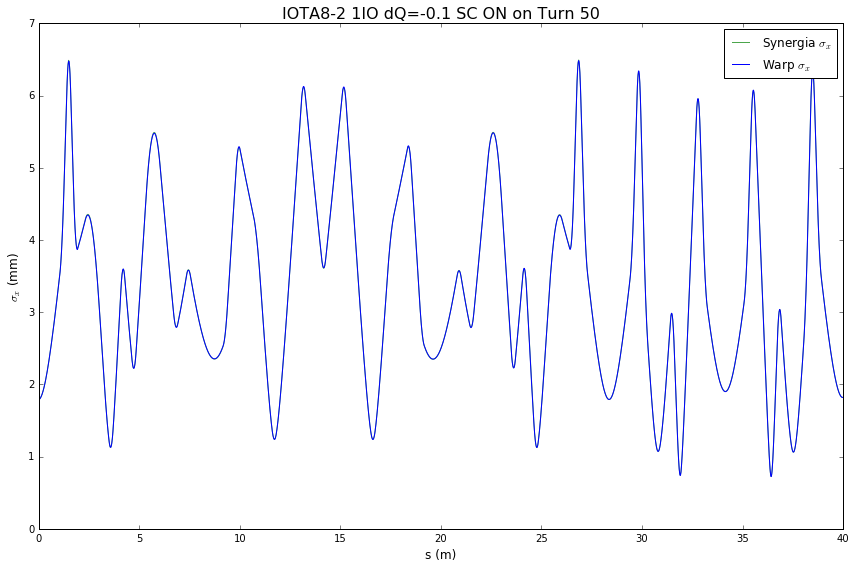

In [336]:
#Plot sig_x
plt.plot(sval_0,xstd[49*interval:50*interval]*1000,'g-',alpha=0.7, label='Synergia $\sigma_x$')
plt.plot(sposW[:],warpSigX[50][:]*1000,label="Warp $\sigma_x$")
plt.legend()

plt.legend()
plt.title("IOTA8-2 1IO dQ=-0.1 SC ON on Turn 50")
plt.xlabel("s (m)")
plt.ylabel("$\sigma_x$ (mm)")

#plt.savefig("sigx_IOTA82_1NL_dQm0p1_50turnWS.eps",format="eps")
plt.show()

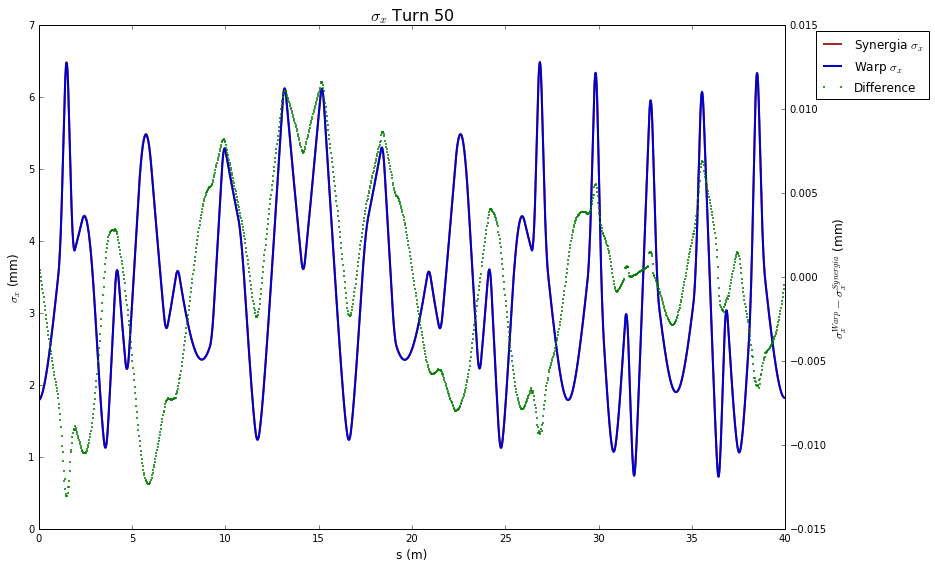

In [369]:
#Plot residual using slice positions from Synergia to find vales from Warp interpolation
fig, ax1 = plt.subplots()
ax1.plot(sval_0,xstd[49*interval:50*interval]*1000,linewidth=2, color='brown', label='Synergia $\sigma_x$')
ax1.plot(sposW[:],warpSigX[50][:]*1000, color='mediumblue',linewidth=2, label="Warp $\sigma_x$")
ax1.set_xlabel("s (m)")
ax1.set_ylabel("$\sigma_x$ (mm)")

ax2 = ax1.twinx()
ax2.plot(sval_0[1:],(fWx50(sval_0[1:])-xstd[49*interval+1:50*interval])*1000,'.',markersize=3, color='g', label="Difference")
ax2.set_ylabel("$\sigma^{Warp}_x - \sigma^{Synergia}_x$ (mm)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0,bbox_to_anchor=(1.2, 1.00))

ax2.set_title("$\sigma_x$ Turn 50")



#plt.savefig("sigx_IOTA82_1NL_dQm0p1_50turnWS.eps",format="eps",bbox_inches='tight')
plt.show()

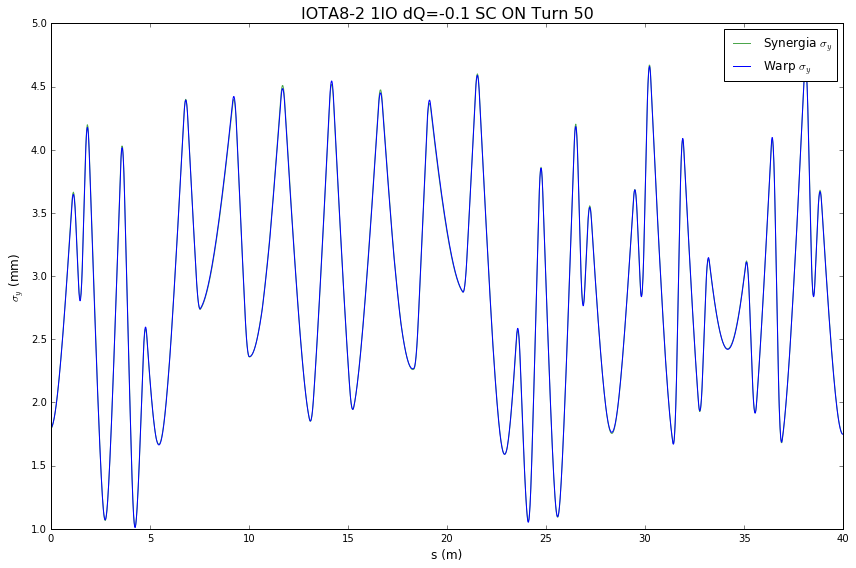

In [339]:
#Plot sig_y
plt.plot(sval_0,ystd[49*interval:50*interval]*1000,'g-',alpha=0.7, label='Synergia $\sigma_y$')
plt.plot(sposW[:],sigy50[:]*1000,label="Warp $\sigma_y$")
plt.legend()

plt.legend()
plt.title("IOTA8-2 1IO dQ=-0.1 SC ON Turn 50")
plt.xlabel("s (m)")
plt.ylabel("$\sigma_y$ (mm)")
plt.savefig("sigy_IOTA82_1NL_dQm0p1_50turnWS.eps",format="eps")
plt.show()

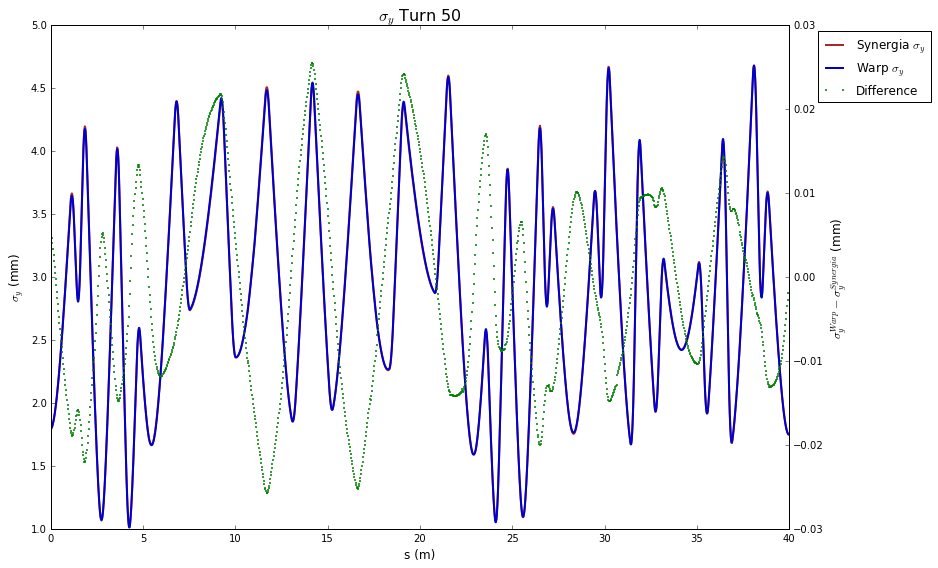

In [370]:
#Plot residual using slice positions from Synergia to find vales from Warp interpolation
fig, ax1 = plt.subplots()
ax1.plot(sval_0,ystd[49*interval:50*interval]*1000,linewidth=2, color='brown', label='Synergia $\sigma_y$')
ax1.plot(sposW[:],warpSigY[50][:]*1000, color='mediumblue',linewidth=2, label="Warp $\sigma_y$")
ax1.set_xlabel("s (m)")
ax1.set_ylabel("$\sigma_y$ (mm)")

ax2 = ax1.twinx()
ax2.plot(sval_0[1:],(fWy50(sval_0[1:])-ystd[49*interval+1:50*interval])*1000,'.',markersize=3, color='g', label="Difference")
ax2.set_ylabel("$\sigma^{Warp}_y - \sigma^{Synergia}_y$ (mm)")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0,bbox_to_anchor=(1.2, 1.00))

ax2.set_title("$\sigma_y$ Turn 50")



#plt.savefig("sigy_IOTA82_1NL_dQm0p1_50turnWS.eps",format="eps",bbox_inches='tight')
plt.show()

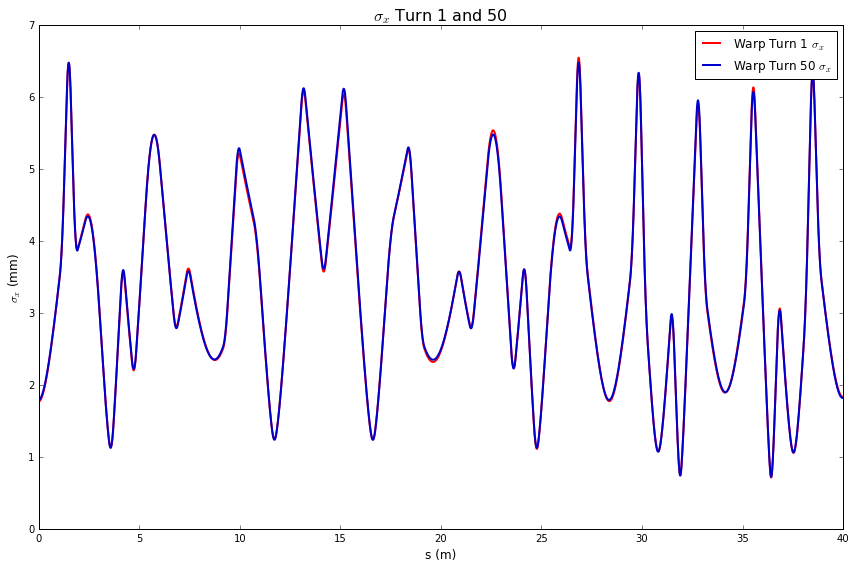

In [430]:
#Plot Warp turn 1 vs turn 50 sig_x
plt.plot(sposW[:],sigx1[:]*1000,'g-',linewidth=2,color='red', label='Warp Turn 1 $\sigma_x$')
plt.plot(sposW[:],warpSigX[50][:]*1000,linewidth=2,color='mediumblue',label="Warp Turn 50 $\sigma_x$")
plt.legend()

plt.legend()
plt.title("$\sigma_x$ Turn 1 and 50")
plt.xlabel("s (m)")
plt.ylabel("$\sigma_x$ (mm)")

#plt.savefig("sigx_IOTA82_1NL_dQm0p1_1-50turnWarp.eps",format="eps")
plt.show()

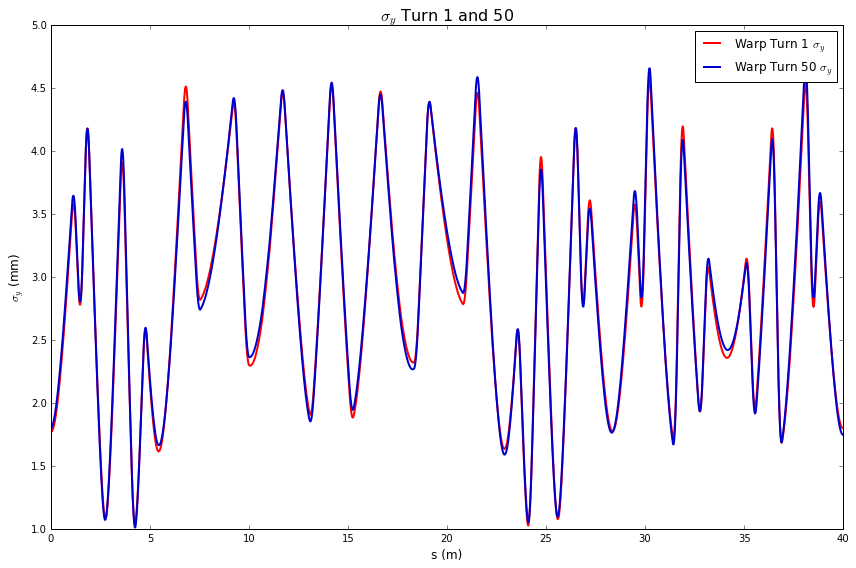

In [372]:
#Plot Warp turn 1 vs turn 50 sig_y
plt.plot(sposW[:],sigy1[:]*1000,'g-',linewidth=2,color='red', label='Warp Turn 1 $\sigma_y$')
plt.plot(sposW[:],warpSigY[50][:]*1000,linewidth=2,color='mediumblue',label="Warp Turn 50 $\sigma_y$")

plt.title("$\sigma_y$ Turn 1 and 50")
plt.xlabel("s (m)")
plt.ylabel("$\sigma_y$ (mm)")
plt.legend()

#plt.savefig("sigy_IOTA82_1NL_dQm0p1_1-50turnWarp.eps",format="eps")
plt.show()

0.00572613385651
-0.00549205399721


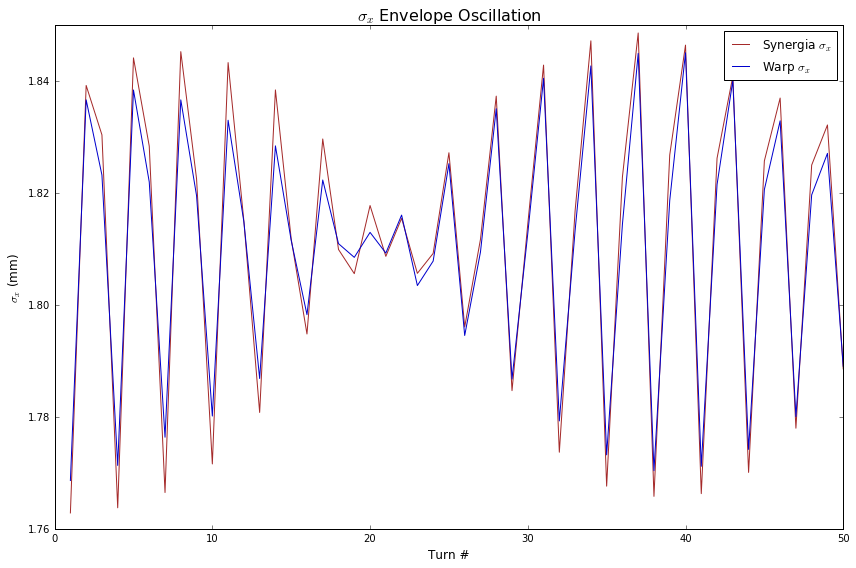

In [373]:
xEnvW = []
yEnvW = []
for i in range(50):
    xEnvW.append(warpSigX[i+1][0])
    yEnvW.append(warpSigY[i+1][0])   
    
plt.plot(rms_array[:50,0]+1,rms_array[:50,1]*1000,color='brown', label = 'Synergia $\sigma_x$')
plt.plot(np.arange(50)+1,np.array(xEnvW)*1000,color='mediumblue', label = 'Warp $\sigma_x$')

plt.legend()
plt.title("$\sigma_x$ Envelope Oscillation")
plt.xlabel("Turn #")
plt.ylabel("$\sigma_x$ (mm)")

#plt.savefig("sigx_IOTA82_1NL_dQm0p1_envelope.eps",format="eps")
print np.max(rms_array[:50,1] - xEnvW) / 1.80e-3
print np.min(rms_array[:50,1] - xEnvW) /1.80e-3

plt.show()

0.0069230073989
-0.00324018318222


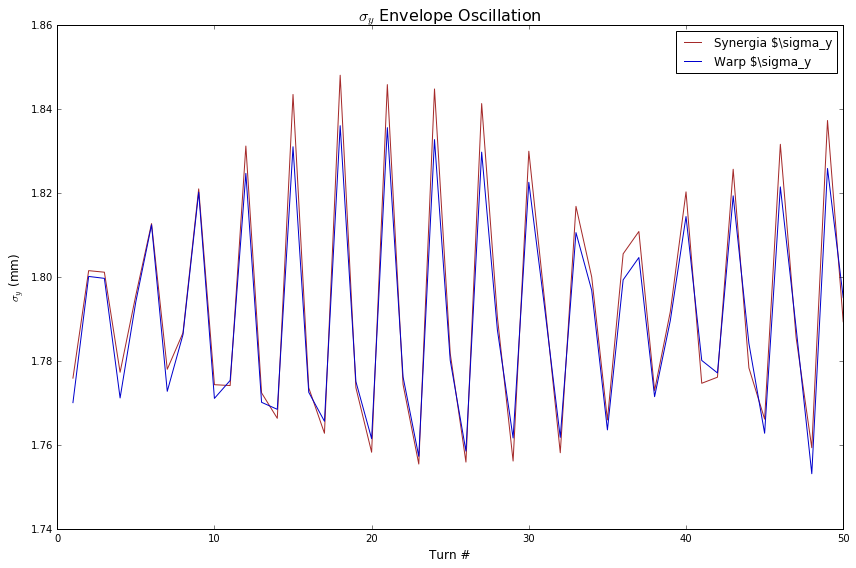

In [374]:
plt.plot(rms_array[:50,0]+1,rms_array[:50,2]*1000,color='brown', label = 'Synergia $\sigma_y')
plt.plot(np.arange(50)+1,np.array(yEnvW)*1000,color='mediumblue', label = 'Warp $\sigma_y')

plt.legend()
plt.title("$\sigma_y$ Envelope Oscillation")
plt.xlabel("Turn #")
plt.ylabel("$\sigma_y$ (mm)")

#plt.savefig("sigy_IOTA82_1NL_dQm0p1_envelope.eps",format="eps")
print np.max(rms_array[:50,2] - yEnvW) / 1.8e-3
print np.min(rms_array[:50,2] - yEnvW) / 1.8e-3
plt.show()

# Warp/Synergia Comparison with Zero Current

In [397]:
#Load rms xy from Warp with Dedge included
warpDataZC = np.loadtxt('twiss_iota82-dQ0p1_ZC.txt')

In [415]:
betax = []
betay = []
alphax = []
alphay = []
spos = []

sliced_twiss = lfplot.get_sliced_lf_fns(lattice_dict['t1_1IO_82_dQ_1']['lattice'],lattice_dict['t1_1IO_82_dQ_1']['lattice_simulator'])
for elem in sliced_twiss:
    betax.append(elem['beta_x'])
    betay.append(elem['beta_y'])
    alphax.append(elem['alpha_x'])
    alphay.append(elem['alpha_y'])
    spos.append(elem['s'])

print spos[3077],warpDataZC[:,0]

39.9682297158 [  9.99205743e-03   1.99841149e-02   2.99761723e-02 ...,   3.99482456e+01
   3.99582377e+01   3.99682297e+01]


In [401]:
fWxZC = interp1d(warpDataZC[:,0],warpDataZC[:,1],kind='cubic')
fWyZC = interp1d(warpDataZC[:,0],warpDataZC[:,2],kind='cubic')

ValueError: operands could not be broadcast together with shapes (1365,) (3067,) 

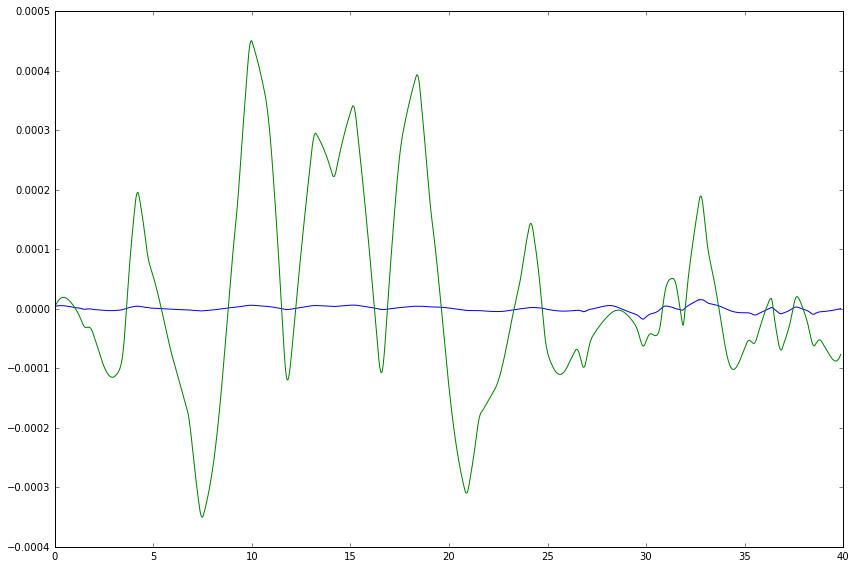

In [429]:
plt.plot(spos[3:3070],np.sqrt(5e-6*np.array(betax[3:3070]))-np.sqrt(5e-6*fWxZC(spos[3:3070])))
plt.plot(spos[3:3070],np.sqrt(5e-6*np.array(betax[3:3070]))-fWx1(spos[3:3070]))
plt.plot(spos[3:3070],np.sqrt(xstd_0[3:3070])-np.sqrt(20e-6*fWxZC(spos[3:3070])))

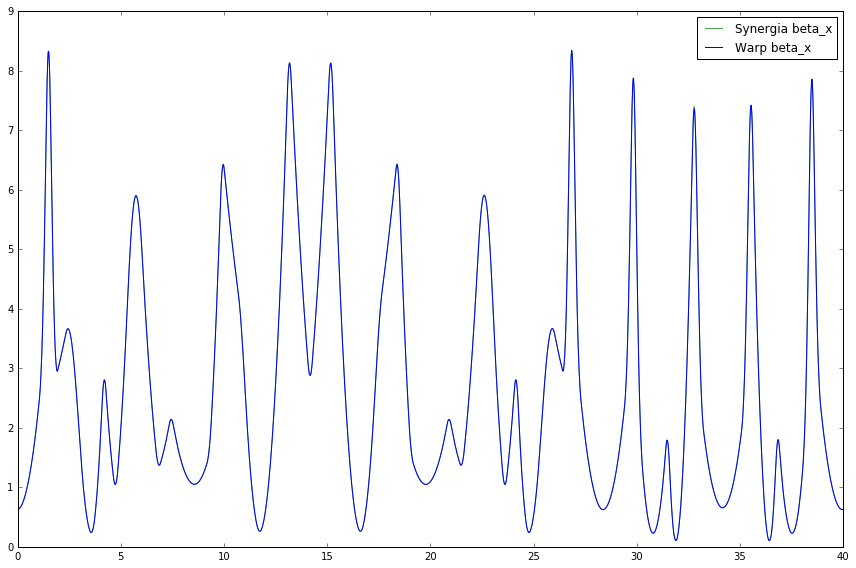

In [399]:
#Plot sig_x
plt.plot(spos,betax,'g-',alpha=0.7, label='Synergia beta_x')
plt.plot(warpDataZC[:,0],warpDataZC[:,1],label="Warp beta_x")
plt.plot(spos,warpDataZC[:,1]-fWxZC(spos))
plt.legend()
#plt.savefig("betax_IOTA6-6_2NL.png",format="png")
plt.show()

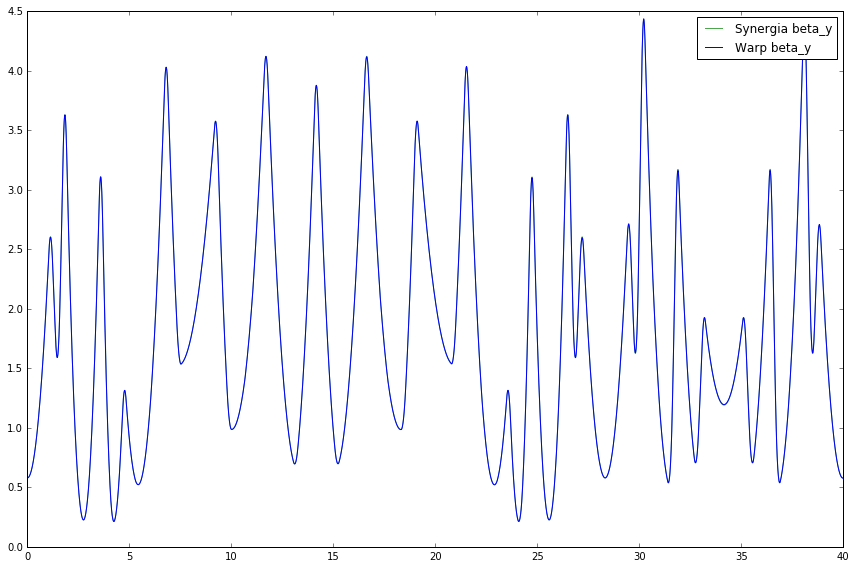

In [400]:
#Plot sig_x
plt.plot(spos,betay,'g-',alpha=0.7, label='Synergia beta_y')
plt.plot(warpDataZC[:,0],warpDataZC[:,2],label="Warp beta_y")
plt.legend()
#plt.savefig("betax_IOTA6-6_2NL.png",format="png")
plt.show()